In [25]:
import itertools
import numpy as np
from util_tools.helper import *
import matplotlib.pyplot as plt
from util_tools.operators import *
from util_tools.update_funcs import *
#problem constants
var_dict = {}
nu_c=var_dict['nu_c']=1e-6
mu_c=var_dict['mu_c']=1e-3
rho_c=var_dict['rho_c']=1e+3
st_coef=0.06
#real timestep
dt=0.0000000001
gradP=-2.4
from tqdm import tqdm
n_iter=0
global epstot
'''
node generation section
'''
#domain length

Lx1=0.04;Lx2=0.02;r_dpl=Lx2/4;M=3.0;u1_ave=0.0125;nx1=100;nx2=50;Nx1=nx1+1;Nx2=nx2+2
h=Lx1/nx1

#var_dict = {'Lx1' : Lx1, 'Lx2' : Lx2, 'r_dpl': r_dpl,'h': h,'u1_ave'  : u1_ave,'M':M,nx1=100;nx2=50,Nx1=nx1+1,Nx2=nx2+1,'dt':dt,'gradP':gradP,'st_coef':st_coef,'nu_c':nu_c,'mu_c':mu_c,'rho_c':rho_c}
var_dict = {'Lx1' : Lx1, 'Lx2' : Lx2, 'r_dpl': r_dpl,'h': h,'u1_ave':u1_ave,'Nx1':Nx1,'Nx2':Nx2,'M' : M,'nx1':nx1,'nx2':nx2,'dt':dt,'gradP':gradP,'st_coef':st_coef,'nu_c':nu_c,'mu_c':mu_c,'rho_c':rho_c}

#Initialization
un=np.zeros([Nx1,Nx2])
us=np.zeros([Nx1,Nx2])
unn=np.zeros([Nx1,Nx2])
u_ref=np.zeros([Nx1,Nx2])

vn=np.zeros([Nx1,Nx2])
vs=np.zeros([Nx1,Nx2])
vnn=np.zeros([Nx1,Nx2])
#u_ref=np.zeros([UNx1+1,UNx2])


pn=np.zeros([nx1,nx2])
pnn=np.zeros([nx1,nx2])


rho=np.zeros([nx1,nx2])
mu=np.zeros([nx1,nx2])



phin=np.zeros( [nx1,nx2] )
phis=np.zeros([nx1,nx2])
phinn=np.zeros([nx1,nx2])

Tx1,Tx2=17,15

#half_index_grid
hig_x, hig_y = np.meshgrid(np.linspace(0, Lx1, num=Nx1),np.linspace(0-h, Lx2,Nx2),indexing='ij')
# #full_index_grid
xi, xj = np.meshgrid(np.round(np.linspace(0+h/2, Lx1-h/2, num=nx1),4),np.round(np.linspace(0+h/2, Lx2-h/2,nx2),4),indexing='ij')

# #lvlset init
phin_int=lvlset_init(xi, xj,var_dict)
phin=phin_int.copy()

rho_int=rho_distr(phin,var_dict)
rho=rho_int.copy()

mu_int=mu_distr(phin,var_dict)
mu=mu_int.copy()

un=ref_vel_prof(hig_y)

In [29]:
h

0.0004

In [10]:
CFL

0.3125

In [26]:
for _ in tqdm(range(10)):
    us=predictor(un,vn, mu, rho, us,var_dict)
    us=BC_looper(us)
    res=1000
    while res>1e-3:
        pnn=projector( us, vs, pn,rho, pnn,var_dict)
        res1=res
        res=LA.norm(pnn-pn)
        if abs(res-res1)<1e-5:
            break
        pn=pnn.copy()
    unn=corrector(us, pnn, unn, rho,var_dict)
    unn=BC_looper(unn)

    L_phi_s,phis=phis_predictor(phis,phin,un,vn,var_dict)
    phis=BC_looper(phis)

    phinn=phinn_corrector(L_phi_s,phinn,phin,un,vn,var_dict)
    phinn=BC_looper(phinn)

    phin=phinn.copy()
    rho=rho_distr(phin,var_dict)
    mu=mu_distr(phin,var_dict)
    tr=np.where(unn==0,0.0001,unn)
    tr=np.where(tr<=1e5,tr,False)
    if np.all(tr)==False:
        break
    un=unn.copy()
    #var_dict['dt']=var_dict['dt']/5 
u=inter_polator(un,var_dict)

100%|███████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.92it/s]


In [28]:
un

array([[-0.01874998,  0.01874998,  0.01871998, ..., -0.05037002,
        -0.05327994,  0.05327994],
       [-0.01874998,  0.01874998,  0.01872   , ..., -0.05037   ,
        -0.05327994,  0.05327994],
       [-0.01874998,  0.01874998,  0.01872   , ..., -0.05037   ,
        -0.05327994,  0.05327994],
       ...,
       [-0.01874998,  0.01874998,  0.01871996, ..., -0.05037004,
        -0.05327994,  0.05327994],
       [-0.01874998,  0.01874998,  0.01871998, ..., -0.05037002,
        -0.05327994,  0.05327994],
       [-0.01874998,  0.01874998,  0.01872   , ..., -0.05037   ,
        -0.05327994,  0.05327994]])

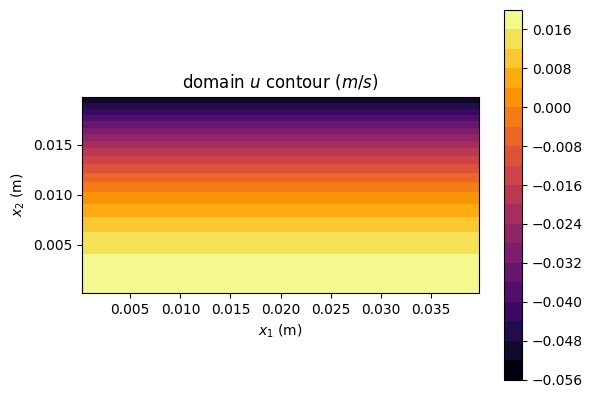

In [27]:
plt.contourf(xi, xj, u, 20, cmap='inferno')
plt.colorbar()
plt.xlabel('$x_1$ (m)')
plt.ylabel('$x_2$ (m)')
plt.title('domain $u$ contour ($m/s$)')
plt.gca().set_aspect('equal')
plt.show()

In [ ]:
plt.contourf(xi, xj, pos_dist, 20, cmap='inferno')
plt.colorbar()
plt.xlabel('$x_1$ (m)')
plt.ylabel('$x_2$ (m)')
plt.title('domain $p$ contour ($m/s$)')
plt.gca().set_aspect('equal')
plt.show()

In [ ]:
pos_dist=np.where(phin>0,phin,0)

In [ ]:
pos_dist

In [ ]:
cols=pd.DataFrame(phin.T).columns
new_cols=[]

In [ ]:
phin_df=pd.DataFrame(phin.T)

In [ ]:
type(cols[1])

In [ ]:
for _ in range(len(cols)):
    new_cols.append('col'+ str(cols[_]))

In [ ]:
phin_df.columns=new_cols

In [ ]:
np.all(np.where(tr>=1e5,tr,False))

In [ ]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

In [ ]:
ax = plt.figure().add_subplot(projection='3d')
# Plot the 3D surface
#ax.plot_surface(xi, xj, phin_int, edgecolor='royalblue', lw=0.1, alpha=0.3)
#ax.contourf(xi, xj, phin, zdir='y', offset=0.004, cmap='coolwarm')
#ax.contourf(xi, xj, phin, zdir='z', cmap='coolwarm')
ax.contourf(xi, xj, phin, zdir='z', cmap='coolwarm')
#ax.contourf(xi, xj, phin, zdir='x',offset=0.01, cmap='coolwarm')
ax.set(xlim=(0, 0.04), ylim=(0, 0.02),zlim=(-0.005, 0.005),xlabel='X', ylabel='Y', zlabel='Z')
plt.show()

In [ ]:
ax = plt.figure().add_subplot(projection='3d')
# Plot the 3D surface
ax.plot_surface(xi, xj, phin_int, edgecolor='royalblue', lw=0.1, alpha=0.3)
#ax.contourf(xi, xj, phin, zdir='y', offset=0.004, cmap='coolwarm')
ax.contourf(xi, xj, phin_int, zdir='z', offset=0, cmap='coolwarm')
#ax.contogurf(xi, xj, phin_int, zdir='x',offset=0.01, cmap='coolwarm')
#ax.colorbar()


In [ ]:
phin[0]

In [ ]:
phin_int[0]

In [ ]:
phin_int[1,:]

In [ ]:
phin_int[:,0]

In [ ]:
phin_int[:,:]

In [ ]:
phin_int[:,4].shape